# Cell painting data phenotype definition

In this notebook we load the [Rosetta](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10012424/) cell painting data (cpg-0003) and create a binary phenotype definition.

In [192]:
# Setup and imports
import numpy as np
import pandas as pd
# import dask.dataframe as dd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import pycytominer
%matplotlib inline

In [193]:
# Data locations
# We are interested in the genetic perturbation datasets, and there is one for each of the two cell lines
profile_uri_template = (
    "s3://cellpainting-gallery/cpg0003-rosetta/"
    "broad/workspace/preprocessed_data/"
    "{dataset}/CellPainting/"
    "replicate_level_cp_{processing}.csv.gz"
)

datasets = ("LUAD-BBBC041-Caicedo", "TA-ORF-BBBC037-Rohban")
processing_levels = ("augmented", "normalized", "normalized_variable_selected")

## A549 data (LUAD-BBBC041-Caicedo)

In [194]:
# Let's take a look at the A549 data
a549_profiles = pd.read_csv(
    profile_uri_template.format_map({'dataset': datasets[0], 'processing': 'augmented'}),
    storage_options={'anon': True},
    dtype={'NCBIGeneID': 'str'}
)

a549_profiles

/tmp/ipykernel_463/3981255583.py:2: DtypeWarning: Columns (1814) have mixed types. Specify dtype option on import or set low_memory=False.
  a549_profiles = pd.read_csv(


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_NCBIGeneID,Metadata_pert_type,Metadata_PublicID,Metadata_Transcript,Metadata_VirusPlateName,...,PublicID,Vector,Transcript,Symbol,x_mutation_status,NCBIGeneID,OtherDescriptions,InsertLength,pert_type,control_type
0,52657,a01,52657,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
1,52665,a01,52665,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
2,52653,a01,52653,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
3,52663,a01,52663,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
4,52649,a01,52649,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,...,EMPTY,NaN,NaN,NaN,negcon,NaN,NaN,NaN,control,negcon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,52674,p24,52674,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6140,52652,p24,52652,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6141,52654,p24,52654,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN
6142,52662,p24,52662,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,...,BRDN0000554157,pLX_TRC317,NM_002392.3:c.662C>G,MDM2,MDM2_p.S221C,4193.0,E3 ubiquitin-protein ligase Mdm2|MDM2 oncogene...,1491.0,trt,NaN


In [195]:
# CellProfiler features start with: 'Nuclei_', 'Cells_', 'Cytoplasm_'
a549_feature_cols = a549_profiles.columns[
    a549_profiles.columns.str.startswith('Nuclei_') |
    a549_profiles.columns.str.startswith('Cells_') |
    a549_profiles.columns.str.startswith('Cytoplasm_')
]

# We will identigy control by Metadata_pert_type == 'control'
# Relevant metadata for deliverables: 'Metadata_Plate', 'Metadata_Well', 'Symbol', 'NCBIGeneID'
meta_cols = ['Metadata_Plate', 'Metadata_Well', 'Symbol', 'NCBIGeneID']

In [196]:
# Get normalized profiles
normalized_a549_profiles = a549_profiles.set_index(meta_cols).groupby('Metadata_Plate', group_keys=False).apply(
    pycytominer.normalize,
    # profiles is first positional argument
    # features=list(feature_cols),
    # image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_pert_type == 'control'"
)

In [197]:
normalized_a549_profiles

,,,,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_NCBIGeneID,Metadata_pert_type,Metadata_PublicID,Metadata_Transcript,Metadata_VirusPlateName,Metadata_x_mutation_status,Metadata_broad_sample,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
Metadata_Plate,Metadata_Well,Symbol,NCBIGeneID,,,,,,,,,,,,,,,,,,,,,
52657,a01,NaN,NaN,52657,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,EMPTY,EMPTY,...,2.039001,0.877942,1.048358,1.002555,0.295731,-0.344131,-0.613980,-0.979494,-1.331597,-1.409100
52665,a01,NaN,NaN,52665,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,EMPTY,EMPTY,...,4.102748,3.316567,3.724476,3.694068,3.856178,3.718479,3.753965,3.510895,2.508507,1.906186
52653,a01,NaN,NaN,52653,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,EMPTY,EMPTY,...,2.714817,-0.341603,0.043840,-0.079110,-0.523051,-0.326106,-0.480346,-1.278005,-1.185864,-1.190897
52663,a01,NaN,NaN,52663,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,EMPTY,EMPTY,...,0.370267,-0.614850,-0.373305,-0.312581,-1.176517,-0.747886,-0.976032,0.443831,0.097625,0.411820
52649,a01,NaN,NaN,52649,DOC45.46.47.48,a01,NaN,control,EMPTY,NaN,DOC45.46.47.48,EMPTY,EMPTY,...,1.784756,0.449389,0.553030,0.503067,-1.136378,-0.539129,-0.466594,0.367607,-0.011845,0.146986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52674,p24,MDM2,4193.0,52674,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,MDM2_p.S221C,BRDN0000554157,...,-2.777390,2.143682,4.413624,3.507907,1.619651,3.715647,3.604033,2.164387,-0.394424,-0.059735
52652,p24,MDM2,4193.0,52652,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,MDM2_p.S221C,BRDN0000554157,...,-4.723289,1.187682,4.612324,3.359147,2.310898,9.518276,9.814691,5.140537,2.658068,1.681905
52654,p24,MDM2,4193.0,52654,DOC49.50.51.52,p24,4193.0,trt,BRDN0000554157,NM_002392.3:c.662C>G,DOC49.50.51.52,MDM2_p.S221C,BRDN0000554157,...,-4.942243,1.950761,4.992101,3.639839,3.682944,8.508531,7.581421,5.695630,1.945149,1.569222


In [198]:
# Get SD counts
a549_sd2 = (normalized_a549_profiles[a549_feature_cols].abs() > 2).sum(axis='columns')

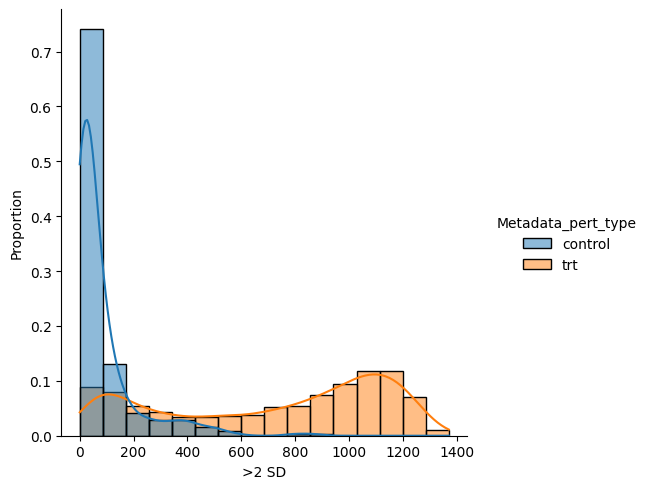

In [199]:
annotated_a549_sd2 = pd.concat(
    [normalized_a549_profiles[['Metadata_pert_type']], a549_sd2.to_frame(name='>2 SD')],
    axis='columns'
)

sns.displot(
    data=annotated_a549_sd2,
    x='>2 SD',
    hue='Metadata_pert_type',
    kde=True,
    common_norm=False,
    stat='proportion'
)

We define our thresholds based on the counts of features that are greater than 2 standard deviations from the mean.

* A positive label (representing morphological change) is given to counts above the point where the perturbation density surpasses 5 times the control density.
* A negative label (representing the absence of morphological change) is given to counts below the point where the control density surpasses the the perturbation` density.

In [200]:
control_a549_kde = gaussian_kde(
    dataset = a549_sd2[annotated_a549_sd2['Metadata_pert_type'] == 'control'],
    bw_method='scott'
)

In [201]:
trt_a549_kde = gaussian_kde(
    dataset = a549_sd2[annotated_a549_sd2['Metadata_pert_type'] == 'trt'],
    bw_method='scott'
)

In [202]:
a549_range_array = np.arange(len(a549_feature_cols))
a549_pt = np.where(control_a549_kde(a549_range_array)*5 < trt_a549_kde(a549_range_array))[0][0]
a549_nt = np.where(control_a549_kde(a549_range_array) < trt_a549_kde(a549_range_array)*1)[0][0]

a549_pt, a549_nt

(556, 184)

In [203]:
labeled_a549_df = annotated_a549_sd2.copy()
labeled_a549_df['label'] = 'Indeterminate'
labeled_a549_df.loc[a549_sd2 >= a549_pt, 'label'] = 'Positive'
labeled_a549_df.loc[a549_sd2 <= a549_nt, 'label'] = 'Negative'
labeled_a549_df[['Metadata_pert_type', 'label']].value_counts().sort_index()

Metadata_pert_type  label        
control             Indeterminate      33
                    Negative          284
                    Positive            3
trt                 Indeterminate    1003
                    Negative         1045
                    Positive         3776
Name: count, dtype: int64

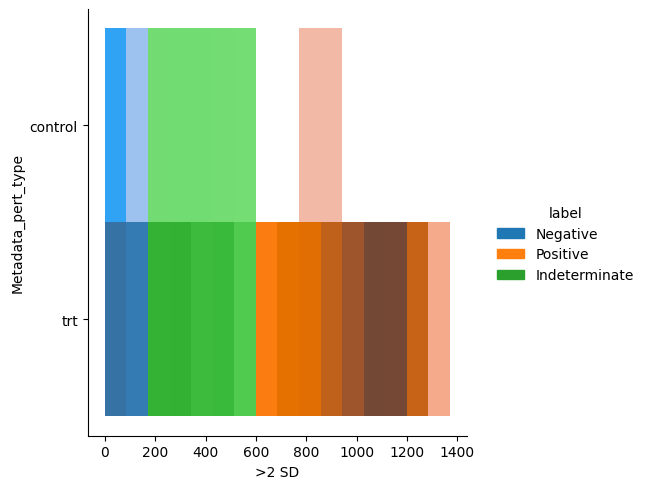

In [204]:
sns.displot(
    data=labeled_a549_df,
    y='Metadata_pert_type',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

### Linking well levels to genes

In [205]:
labeled_a549_df

,,,,Metadata_pert_type,>2 SD,label
Metadata_Plate,Metadata_Well,Symbol,NCBIGeneID,,,
52657,a01,NaN,NaN,control,101,Negative
52665,a01,NaN,NaN,control,866,Positive
52653,a01,NaN,NaN,control,124,Negative
52663,a01,NaN,NaN,control,163,Negative
52649,a01,NaN,NaN,control,25,Negative
...,...,...,...,...,...,...
52674,p24,MDM2,4193.0,trt,1259,Positive
52652,p24,MDM2,4193.0,trt,1258,Positive
52654,p24,MDM2,4193.0,trt,1333,Positive


In [207]:
# Deliverable #1: Labeled wells
labeled_a549_df.to_csv('data/cpg0003/a549/well_labels.csv', index=True)

In [208]:
labeled_a549_trt = labeled_a549_df[labeled_a549_df['Metadata_pert_type'] == 'trt']

labeled_a549_genes = (
    labeled_a549_trt
    .groupby(['Symbol', 'NCBIGeneID'])
    .label
    .value_counts()
    .unstack('label', fill_value=0)
)
labeled_a549_genes

,label,Indeterminate,Negative,Positive
Symbol,NCBIGeneID,,,
ABCB9,23457.0,25,11,4
ACAA1,30.0,0,0,8
ACAT2,39.0,0,0,16
ACD,65057.0,0,0,8
ACKR1,2532.0,7,17,0
...,...,...,...,...
TSTA3,7264.0,0,0,8
U2AF1,7307.0,4,6,14
ZBTB24,9841.0,13,4,39


We need a rule to find "surely positive" and "surely negative" genes.
The approach we will take is to label by the majority.

In [209]:
a549_pls = labeled_a549_genes['Positive']
a549_nls = labeled_a549_genes['Negative']
a549_ils = labeled_a549_genes['Indeterminate']

final_labeled_crispr_genes = labeled_a549_genes.copy()
final_labeled_crispr_genes['gene_label'] = 'Indeterminate'
final_labeled_crispr_genes['gene_label'][a549_pls > a549_nls + a549_ils] = 'Positive'
final_labeled_crispr_genes['gene_label'][a549_nls > a549_pls + a549_ils] = 'Negative'

final_labeled_crispr_genes.gene_label.value_counts()

/tmp/ipykernel_463/683724763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][a549_pls > a549_nls + a549_ils] = 'Positive'
/tmp/ipykernel_463/683724763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_crispr_genes['gene_label'][a549_nls > a549_pls + a549_ils] = 'Negative'


gene_label
Positive         108
Indeterminate     17
Negative          10
Name: count, dtype: int64

In [210]:
# Deliverable #2: gene labels
final_labeled_crispr_genes.to_csv('data/cpg0003/a549/gene_labels.csv')

## U2OS data (TA-ORF-BBBC037-Rohban)

In [211]:
# Let's take a look at the A549 data
u2os_raw_profiles = pd.read_csv(
    profile_uri_template.format_map({'dataset': datasets[1], 'processing': 'augmented'}),
    storage_options={'anon': True},
    dtype={'Metadata_GeneID': 'str'}
)

u2os_raw_profiles

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,Metadata_Treatment,Gene Allele Name,pert_type,control_type
0,41744,a01,41744,TAORF_REFERENCE_SET,a01,EMPTY,EMPTY_,negcon,U2OS,Untreated,...,1.245067,1.300214,1.250547,2.549217,2.549292,2.580768,NaN,NaN,control,negcon
1,41744,a02,41744,TAORF_REFERENCE_SET,a02,EMPTY,EMPTY_,negcon,U2OS,Untreated,...,1.304125,1.409949,1.357492,2.565789,2.571296,2.606567,NaN,NaN,control,negcon
2,41744,a03,41744,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,1.375558,1.413097,1.415326,2.575652,2.621210,2.668294,ATF4_WT.1,ATF4_WT.1,trt,NaN
3,41744,a04,41744,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,1.299621,1.330510,1.304007,2.595669,2.626601,2.649400,TSC2_WT,TSC2_WT,trt,NaN
4,41744,a05,41744,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,1.343384,1.410478,1.379160,2.615251,2.654130,2.695320,BAX_WT,BAX_WT,trt,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,41757,p20,41757,TAORF_REFERENCE_SET,p20,eGFP,eGFP_CTRL,negcon,U2OS,CTRL,...,1.280762,1.338451,1.300881,2.660204,2.710194,2.731972,NaN,NaN,control,negcon
1916,41757,p21,41757,TAORF_REFERENCE_SET,p21,EMPTY,EMPTY_,negcon,U2OS,Untreated,...,1.270993,1.321114,1.289762,2.778403,2.716907,2.769703,NaN,NaN,control,negcon
1917,41757,p22,41757,TAORF_REFERENCE_SET,p22,EMPTY,EMPTY_,negcon,U2OS,Untreated,...,1.304008,1.321635,1.304950,2.657927,2.626585,2.687136,NaN,NaN,control,negcon
1918,41757,p23,41757,TAORF_REFERENCE_SET,p23,EMPTY,EMPTY_,negcon,U2OS,Untreated,...,1.309891,1.378696,1.331808,2.636991,2.641285,2.700773,NaN,NaN,control,negcon


In [212]:
# The 'pert_type' column has the correct perturbation types
u2os_raw_profiles[['Metadata_pert_type', 'pert_type', 'Metadata_GeneID']]

,Metadata_pert_type,pert_type,Metadata_GeneID
0,trt,control,NaN
1,trt,control,NaN
2,trt,trt,468.0
3,trt,trt,7249.0
4,trt,trt,581.0
...,...,...,...
1915,trt,control,NaN
1916,trt,control,NaN
1917,trt,control,NaN
1918,trt,control,NaN


In [213]:
u2os_columns = u2os_raw_profiles.columns

# CellProfiler features start with: 'Nuclei_', 'Cells_', 'Cytoplasm_'
u2os_feature_cols = u2os_columns[
    u2os_columns.str.startswith('Nuclei_') |
    u2os_columns.str.startswith('Cells_') |
    u2os_columns.str.startswith('Cytoplasm_')
]

# We will identigy control by Metadata_pert_type == 'control'
# Relevant metadata for deliverables: 'Metadata_Plate', 'Metadata_Well', 'Symbol', 'NCBIGeneID'

# The U2OS data has different column names and a bad Metadata_pert_type column, correct it here
u2os_profiles = (u2os_raw_profiles
    .drop('Metadata_pert_type', axis='columns')
    .rename(
        columns={
            'Metadata_gene_name': 'Symbol',
            'Metadata_GeneID': 'NCBIGeneID',
            'pert_type': 'Metadata_pert_type'
        }
    )
)

In [214]:
# Get normalized profiles
normalized_u2os_profiles = u2os_profiles.set_index(meta_cols).groupby('Metadata_Plate', group_keys=False).apply(
    pycytominer.normalize,
    # profiles is first positional argument
    # features=list(feature_cols),
    # image_features=True, # Include Image_### features
    method="standardize",
    samples="Metadata_pert_type == 'control'"
)

In [215]:
normalized_u2os_profiles

Metadata_Assay_Plate_Barcode   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                                 
41744          a01           EMPTY  NaN                                41744  \
               a02           EMPTY  NaN                                41744   
               a03           ATF4   468.0                              41744   
               a04           TSC2   7249.0                             41744   
               a05           BAX    581.0                              41744   
...                                                                      ...   
41757          p20           eGFP   NaN                                41757   
               p21           EMPTY  NaN                                41757   
               p22           EMPTY  NaN                                41757   
               p23           EMPTY  NaN                                41757   
               p24           EMPTY  NaN                                41757   

                                               Metadata_Plate_Map_Name   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                           
41744          a01           EMPTY  NaN            TAORF_REFERENCE_SET  \
               a02           EMPTY  NaN            TAORF_REFERENCE_SET   
               a03           ATF4   468.0          TAORF_REFERENCE_SET   
               a04           TSC2   7249.0         TAORF_REFERENCE_SET   
               a05           BAX    581.0          TAORF_REFERENCE_SET   
...                                                                ...   
41757          p20           eGFP   NaN            TAORF_REFERENCE_SET   
               p21           EMPTY  NaN            TAORF_REFERENCE_SET   
               p22           EMPTY  NaN            TAORF_REFERENCE_SET   
               p23           EMPTY  NaN            TAORF_REFERENCE_SET   
               p24           EMPTY  NaN            TAORF_REFERENCE_SET   

                                               Metadata_well_position   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                          
41744          a01           EMPTY  NaN                           a01  \
               a02           EMPTY  NaN                           a02   
               a03           ATF4   468.0                         a03   
               a04           TSC2   7249.0                        a04   
               a05           BAX    581.0                         a05   
...                                                               ...   
41757          p20           eGFP   NaN                           p20   
               p21           EMPTY  NaN                           p21   
               p22           EMPTY  NaN                           p22   
               p23           EMPTY  NaN                           p23   
               p24           EMPTY  NaN                           p24   

                                               Metadata_pert_name   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                      
41744          a01           EMPTY  NaN                    EMPTY_  \
               a02           EMPTY  NaN                    EMPTY_   
               a03           ATF4   468.0               ATF4_WT.1   
               a04           TSC2   7249.0                TSC2_WT   
               a05           BAX    581.0                  BAX_WT   
...                                                           ...   
41757          p20           eGFP   NaN                 eGFP_CTRL   
               p21           EMPTY  NaN                    EMPTY_   
               p22           EMPTY  NaN                    EMPTY_   
               p23           EMPTY  NaN                    EMPTY_   
               p24           EMPTY  NaN                    EMPTY_   

                                               Metadata_broad_sample   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                         
41744          a01           EMPTY  NaN             

In [216]:
# Get SD counts
u2os_sd2 = (normalized_u2os_profiles[u2os_feature_cols].abs() > 2).sum(axis='columns')

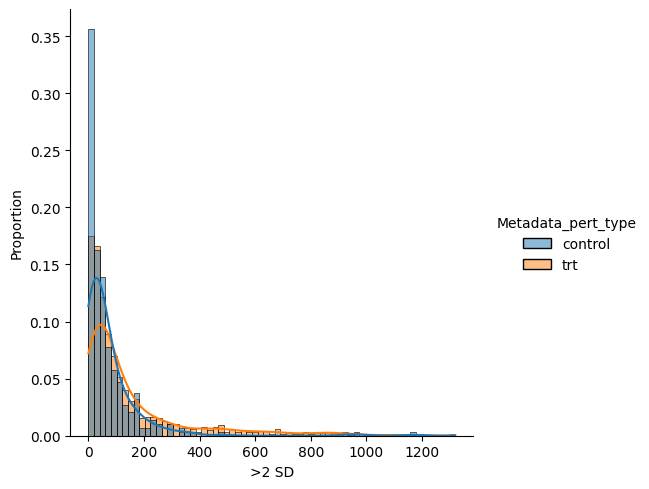

In [217]:
annotated_u2os_sd2 = pd.concat(
    [normalized_u2os_profiles[['Metadata_pert_type']], u2os_sd2.to_frame(name='>2 SD')],
    axis='columns'
)

sns.displot(
    data=annotated_u2os_sd2,
    x='>2 SD',
    hue='Metadata_pert_type',
    kde=True,
    common_norm=False,
    stat='proportion'
)

We define our thresholds based on the counts of features that are greater than 2 standard deviations from the mean.

* A positive label (representing morphological change) is given to counts above the point where the perturbation density surpasses 5 times the control density.
* A negative label (representing the absence of morphological change) is given to counts below the point where the control density surpasses the the perturbation` density.

In [218]:
control_u2os_kde = gaussian_kde(
    dataset = u2os_sd2[annotated_u2os_sd2['Metadata_pert_type'] == 'control'],
    bw_method='scott'
)

In [219]:
trt_u2os_kde = gaussian_kde(
    dataset = u2os_sd2[annotated_u2os_sd2['Metadata_pert_type'] == 'trt'],
    bw_method='scott'
)

In [220]:
u2os_range_array = np.arange(len(u2os_feature_cols))
u2os_pt = np.where(control_u2os_kde(u2os_range_array)*5 < trt_u2os_kde(u2os_range_array))[0][0]
u2os_nt = np.where(control_u2os_kde(u2os_range_array) < trt_u2os_kde(u2os_range_array)*1)[0][0]

u2os_pt, u2os_nt

(410, 89)

In [221]:
labeled_u2os_df = annotated_u2os_sd2.copy()
labeled_u2os_df['label'] = 'Indeterminate'
labeled_u2os_df.loc[u2os_sd2 >= u2os_pt, 'label'] = 'Positive'
labeled_u2os_df.loc[u2os_sd2 <= u2os_nt, 'label'] = 'Negative'
labeled_u2os_df[['Metadata_pert_type', 'label']].value_counts().sort_index()

Metadata_pert_type  label        
control             Indeterminate     64
                    Negative         227
                    Positive           4
trt                 Indeterminate    510
                    Negative         942
                    Positive         173
Name: count, dtype: int64

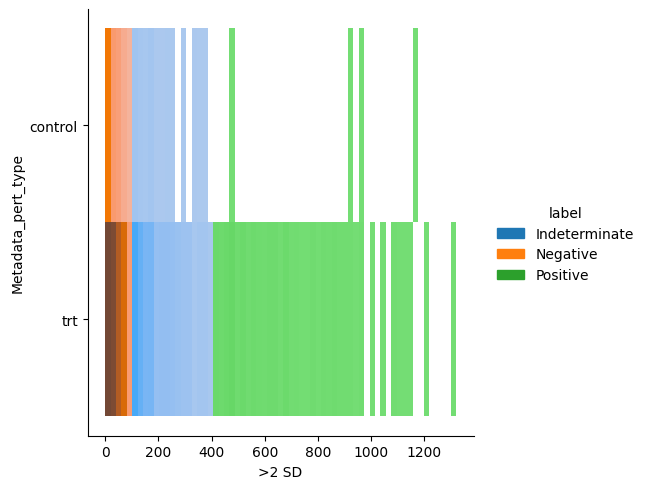

In [222]:
sns.displot(
    data=labeled_u2os_df,
    y='Metadata_pert_type',
    x='>2 SD',
    hue='label',
    #kind='kde'
)

### Linking well levels to genes

In [223]:
labeled_u2os_df

Metadata_pert_type  >2 SD   
Metadata_Plate Metadata_Well Symbol NCBIGeneID                             
41744          a01           EMPTY  NaN                   control    217  \
               a02           EMPTY  NaN                   control     46   
               a03           ATF4   468.0                     trt    193   
               a04           TSC2   7249.0                    trt     70   
               a05           BAX    581.0                     trt     62   
...                                                           ...    ...   
41757          p20           eGFP   NaN                   control     18   
               p21           EMPTY  NaN                   control     24   
               p22           EMPTY  NaN                   control     49   
               p23           EMPTY  NaN                   control     27   
               p24           EMPTY  NaN                   control     27   

                                                        label  
Metadata_Plate Metadata_Well Symbol NCBIGeneID                 
41744          a01           EMPTY  NaN         Indeterminate  
               a02           EMPTY  NaN              Negative  
               a03           ATF4   468.0       Indeterminate  
               a04           TSC2   7249.0           Negative  
               a05           BAX    581.0            Negative  
...                                                       ...  
41757          p20           eGFP   NaN              Negative  
               p21           EMPTY  NaN              Negative  
               p22           EMPTY  NaN              Negative  
               p23           EMPTY  NaN              Negative  
               p24           EMPTY  NaN              Negative  

[1920 rows x 3 columns]

In [224]:
# Deliverable #1: Labeled wells
labeled_u2os_df.to_csv('data/cpg0003/u2os/well_labels.csv', index=True)

In [225]:
labeled_u2os_trt = labeled_u2os_df[labeled_u2os_df['Metadata_pert_type'] == 'trt']

labeled_u2os_genes = (
    labeled_u2os_trt
    .groupby(['Symbol', 'NCBIGeneID'])
    .label
    .value_counts()
    .unstack('label', fill_value=0)
)
labeled_u2os_genes

,label,Indeterminate,Negative,Positive
Symbol,NCBIGeneID,,,
ACVR1B,91.0,2,13,0
ADAM17,6868.0,1,4,0
AKT1,207.0,2,8,5
AKT1S1,84335.0,4,1,5
AKT2,208.0,2,3,0
...,...,...,...,...
WNT5A,7474.0,3,2,0
WWTR1,25937.0,4,0,1
XBP1,7494.0,4,12,4


We need a rule to find "surely positive" and "surely negative" genes.
The approach we will take is to label by the majority.

In [226]:
u2os_pls = labeled_u2os_genes['Positive']
u2os_nls = labeled_u2os_genes['Negative']
u2os_ils = labeled_u2os_genes['Indeterminate']

final_labeled_u2os_genes = labeled_u2os_genes.copy()
final_labeled_u2os_genes['gene_label'] = 'Indeterminate'
final_labeled_u2os_genes['gene_label'][u2os_pls > u2os_nls + u2os_ils] = 'Positive'
final_labeled_u2os_genes['gene_label'][u2os_nls > u2os_pls + u2os_ils] = 'Negative'

final_labeled_u2os_genes.gene_label.value_counts()

/tmp/ipykernel_463/3689009524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_u2os_genes['gene_label'][u2os_pls > u2os_nls + u2os_ils] = 'Positive'
/tmp/ipykernel_463/3689009524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_labeled_u2os_genes['gene_label'][u2os_nls > u2os_pls + u2os_ils] = 'Negative'


gene_label
Negative         118
Indeterminate     60
Positive          12
Name: count, dtype: int64

In [227]:
# Deliverable #2: gene labels
final_labeled_u2os_genes.to_csv('data/cpg0003/u2os/gene_labels.csv')